In [1]:
import xarray as xr

grid_path = "/kaggle/working/misc/grid_info/ClimSim_low-res_grid-info.nc"
grid_info = xr.open_dataset(grid_path)
grid_info

<xarray.Dataset> Size: 14kB
Dimensions:  (time: 1, ncol: 384, ilev: 61, lev: 60)
Coordinates:
  * ilev     (ilev) float64 488B 0.05588 0.1008 0.1814 ... 970.8 985.3 1e+03
  * lev      (lev) float64 480B 0.07835 0.1411 0.2529 ... 963.6 978.0 992.6
Dimensions without coordinates: time, ncol
Data variables:
    P0       float64 8B ...
    PS       (time, ncol) float32 2kB ...
    area     (ncol) float64 3kB ...
    hyai     (ilev) float64 488B ...
    hyam     (lev) float64 480B ...
    hybi     (ilev) float64 488B ...
    hybm     (lev) float64 480B ...
    lat      (ncol) float64 3kB ...
    lon      (ncol) float64 3kB ...
Attributes: (12/19)
    ne:                4
    fv_nphys:          2
    title:             EAM History file information
    source:            E3SM Atmosphere Model
    source_id:         4108bd8c11
    product:           model-output
    ...                ...
    institution_id:    E3SM-Project
    institution:       LLNL (Lawrence Livermore National Laboratory, Livermor...
    contact:           e3sm-data-support@listserv.llnl.gov
    initial_file:      /global/cfs/cdirs/e3sm/inputdata/atm/cam/inic/homme/ea...
    topography_file:   /global/cfs/cdirs/e3sm/inputdata/atm/cam/topo/USGS-gto...
    time_period_freq:  month_1

In [7]:
import numpy as np

latitude = grid_info["lat"].to_numpy()
longitude = grid_info["lon"].to_numpy()
latitude_sin = np.sin(np.radians(latitude))
longitude_sin = np.sin(np.radians(longitude))
longitude_cos = np.cos(np.radians(longitude))

In [30]:
import torch


def get_lat_lon_tensor():
    """
    output: torch.Size([384, 3])
    """
    grid_path = "/kaggle/working/misc/grid_info/ClimSim_low-res_grid-info.nc"
    grid_info = xr.open_dataset(grid_path)
    latitude = grid_info["lat"].to_numpy()
    longitude = grid_info["lon"].to_numpy()
    # 緯度と経度のsinとcosを計算
    latitude_sin = np.sin(np.radians(latitude))
    latitude_cos = np.cos(np.radians(latitude))
    longitude_sin = np.sin(np.radians(longitude))

    # Numpy配列をPyTorchのTensorに変換し、勾配計算を無効にする
    latitude_sin_tensor = torch.tensor(
        latitude_sin, dtype=torch.float32, requires_grad=False
    )
    latitude_cos_tensor = torch.tensor(
        latitude_cos, dtype=torch.float32, requires_grad=False
    )
    longitude_sin_tensor = torch.tensor(
        longitude_sin, dtype=torch.float32, requires_grad=False
    )

    # これらのTensorを1つのデータセットにまとめる
    lat_lon_tensor = torch.stack(
        [latitude_sin_tensor, latitude_cos_tensor, longitude_sin_tensor], dim=1
    )
    return lat_lon_tensor

In [32]:
lat_lon_tensor = get_lat_lon_tensor()
lat_lon_tensor.shape

torch.Size([384, 3])

In [38]:

x_lat_lon = lat_lon_tensor.repeat(4, 1, 1)  # (batch, 384, 3)
x_lat_flatten = x_lat_lon.flatten(start_dim=0, end_dim=1)
x_lat_flatten.shape

torch.Size([1536, 3])

In [39]:
x_lat_flatten = x_lat_flatten.unsqueeze(1).repeat(1, 60, 1)
x_lat_flatten.shape

torch.Size([1536, 60, 3])

In [6]:
!python -m pip install basemap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 936.0/936.0 kB 5.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 52.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 7.2 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.0
    Uninstalling packaging-24.0:
      Successfully uninstalled packaging-24.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf 23.8.0 requires cubinlinker, which is not installed.
cudf 23.8.0 requires cupy-cuda11x>=12.0.0, which is not installed.
cudf 23.8.0 requires ptxcompiler, which is not installed.
cuml 23.8.0 requires cupy-cuda11x>=12.0.0, which is not installed.
dask-cudf 23.8.0 requires cupy-cuda11x>=12.0.0, which is not installed.
keras-cv 0.8.2 requires keras-core, which is not installed.
keras-nlp 0.8.2 requires 

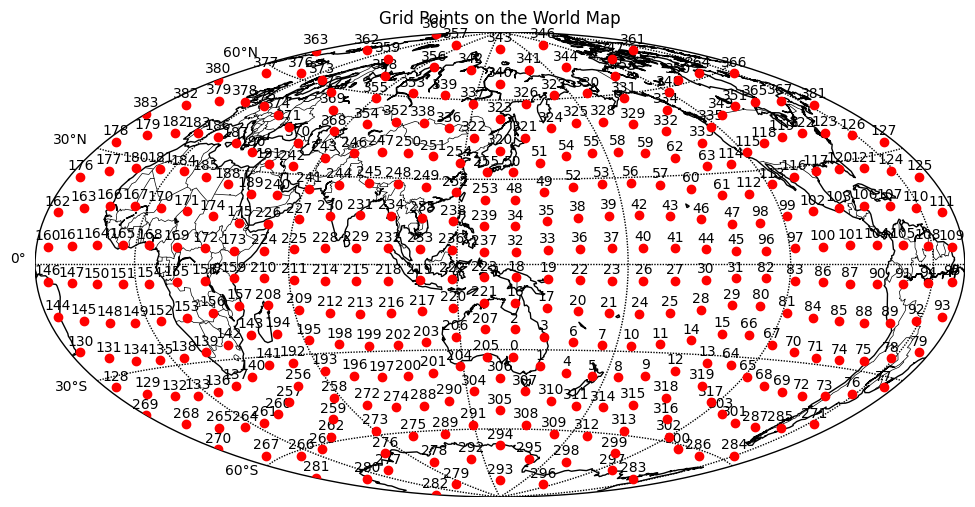

In [19]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.basemap import Basemap

# 仮の緯度経度データを生成します（384個のデータ点）
latitude = grid_info["lat"]
longitude = grid_info["lon"] - 180

# 地図の投影を設定します
plt.figure(figsize=(12, 8))
# m = Basemap(projection="robin", lon_0=0, resolution="l")  # cyl projection='robin'
# m = Basemap(projection='aeqd', lon_0 = 10, lat_0 = 50)
# m = Basemap(projection="moll", lon_0=135, resolution="c")
m = Basemap(projection="hammer", lon_0=135, resolution="c")


# 地図に海岸線、国境、グリッド線を描画します
m.drawcoastlines()
m.drawcountries()
m.drawparallels(np.arange(-90.0, 91.0, 30.0), labels=[1, 0, 0, 0])
m.drawmeridians(np.arange(-180.0, 181.0, 60.0), labels=[0, 0, 0, 1])

# 緯度経度データをプロットします
x, y = m(longitude, latitude)
m.scatter(x, y, marker="o", color="r", zorder=5)

# 各ポイントに番号を表示します
for i in range(len(latitude)):
    plt.annotate(
        str(i), (x[i], y[i]), textcoords="offset points", xytext=(0, 5), ha="center"
    )

# タイトルを追加します
plt.title("Grid Points on the World Map")

# グラフを表示します
plt.show()